In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, set_seed
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logging
import torch.nn as nn
from scipy.stats import mode
import warnings
warnings.filterwarnings("ignore")

# Set seeds and device
set_seed(42)
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model configurations
MODEL_CONFIGS = {
    "mBERT": {
        "learning_rate": 2e-5,
        "batch_size": 32,
        "epochs": 12,
        "weight_decay": 0.1,
        "gradient_accumulation": 1,
        "warmup_ratio": 0.2
    },
    "XLM-R": {
        "learning_rate": 2e-5,
        "batch_size": 16,
        "epochs": 14,
        "weight_decay": 0.05,
        "gradient_accumulation": 2,
        "warmup_ratio": 0.1
    },
    "MuRIL": {
        "learning_rate": 3e-5,
        "batch_size": 16,
        "epochs": 12,
        "weight_decay": 0.01,
        "gradient_accumulation": 1,
        "warmup_ratio": 0.1
    },
    "Tamil-BERT": {
        "learning_rate": 2e-5,
        "batch_size": 16,
        "epochs": 14,
        "weight_decay": 0.01,
        "gradient_accumulation": 1,
        "warmup_ratio": 0.1
    },
    "Tamilhate-BERT": {
        "learning_rate": 1e-5,
        "batch_size": 16,
        "epochs": 12,
        "weight_decay": 0.01,
        "gradient_accumulation": 1,
        "warmup_ratio": 0.1
    }
}

MODELS = {
    "Tamil-BERT": "l3cube-pune/tamil-bert",
    "Tamilhate-BERT": "mdosama39/tamil-bert-Caste-HateSpech_LTEDi-tamil",
    "MuRIL": "google/muril-base-cased",
    "mBERT": "bert-base-multilingual-cased",
    "XLM-R": "xlm-roberta-base",
}

Using device: cuda


In [2]:
# Cell 2: Data Loading and Class Distribution
def load_data():
    train_df = pd.read_csv("train.csv")
    dev_df = pd.read_csv("dev.csv")
    test_df = pd.read_csv("test_with_labels.csv")

    print("\nClass Distribution:")
    print(f"Train: {train_df['label'].value_counts()}")
    print(f"Test: {test_df['label'].value_counts()}")

    return train_df, dev_df, test_df

train_df, dev_df, test_df = load_data()


Class Distribution:
Train: label
0    3415
1    2097
Name: count, dtype: int64
Test: label
0    970
1    606
Name: count, dtype: int64


In [3]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = [text.strip() for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [4]:
def test_analysis(model, tokenizer, test_data):
    test_dataset = HateSpeechDataset(
        test_data['text'].tolist(),
        test_data['label'].tolist(),
        tokenizer
    )

    trainer = Trainer(model=model)
    predictions = trainer.predict(test_dataset)
    pred_labels = np.argmax(predictions.predictions, axis=-1)

    print("\nClassification Report:")
    print(classification_report(test_data['label'], pred_labels,
                               target_names=['Non-Hate', 'Hate']))

    plt.figure(figsize=(6,4))
    cm = confusion_matrix(test_data['label'], pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'])
    plt.title('Test Confusion Matrix')
    plt.show()

    return pred_labels

In [5]:
def train_model(model_name, train_data, dev_data, test_data):
    config = MODEL_CONFIGS[model_name]
    tokenizer = AutoTokenizer.from_pretrained(MODELS[model_name])
    model = AutoModelForSequenceClassification.from_pretrained(MODELS[model_name], num_labels=2).to(device)

    # Dataset creation
    train_dataset = HateSpeechDataset(
        train_data['text'].tolist(),
        train_data['label'].tolist(),
        tokenizer
    )

    dev_dataset = HateSpeechDataset(
        dev_data['text'].tolist(),
        dev_data['label'].tolist(),
        tokenizer
    )

    # Class weights calculation
    class_counts = train_data['label'].value_counts().sort_index()
    total = len(train_data)
    class_weights = torch.tensor([
        total/(2*class_counts[0]),
        total/(2*class_counts[1])
    ], dtype=torch.float).to(device)

    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            loss_fct = nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(outputs.logits, labels)
            return (loss, outputs) if return_outputs else loss

    training_args = TrainingArguments(
        output_dir=f'./{model_name}_results',
        learning_rate=config["learning_rate"],
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        num_train_epochs=config["epochs"],
        weight_decay=config["weight_decay"],
        logging_strategy='steps',
        logging_steps=50,
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=config["gradient_accumulation"],
        lr_scheduler_type="linear",
        warmup_ratio=config["warmup_ratio"],
        report_to='none'
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        compute_metrics=lambda p: {
            'f1': f1_score(p.label_ids, p.predictions.argmax(-1), average='macro'),
            'accuracy': (p.predictions.argmax(-1) == p.label_ids).mean()
        },
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    results = trainer.evaluate()

    # Test analysis
    print(f"\n{model_name} Test Results:")
    test_preds = test_analysis(model, tokenizer, test_data)

    return model, tokenizer, results, test_preds

In [6]:
class EnsembleSystem:
    def __init__(self, models, val_f1_scores):
        self.models = models
        self.weights = np.log(np.array(val_f1_scores)) + 1
        self.weights /= self.weights.sum()

    def predict(self, texts, method='weighted_voting'):
        all_preds = []
        all_probs = []

        for model, tokenizer in self.models:
            dataset = HateSpeechDataset(texts, [0]*len(texts), tokenizer)
            dl = DataLoader(dataset, batch_size=32)

            preds = []
            probs = []
            model.eval()
            with torch.no_grad():
                for batch in dl:
                    inputs = {
                        'input_ids': batch['input_ids'].to(device),
                        'attention_mask': batch['attention_mask'].to(device)
                    }
                    outputs = model(**inputs)
                    preds.extend(outputs.logits.argmax(-1).cpu().numpy())
                    probs.extend(softmax(outputs.logits.cpu().numpy(), axis=1))
            all_preds.append(preds)
            all_probs.append(probs)

        if method == 'voting':
            return mode(np.array(all_preds), axis=0)[0].squeeze()
        elif method == 'averaging':
            avg_probs = np.mean(all_probs, axis=0)
            return avg_probs.argmax(axis=1)
        elif method == 'weighted_voting':
            weighted_probs = np.average(all_probs, axis=0, weights=self.weights)
            return weighted_probs.argmax(axis=1)
        else:
            raise ValueError("Invalid ensemble method")


Training Tamil-BERT


tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/tamil-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.690300,0.680588,0.579242,0.579416
2,0.651700,0.648034,0.609871,0.609911
3,0.541100,0.576202,0.720598,0.735705
4,0.409600,0.630294,0.688401,0.688691
5,0.266900,0.718336,0.760220,0.789072
6,0.318400,0.780837,0.755943,0.780178
7,0.175400,0.781655,0.787816,0.796696
8,0.134900,0.856285,0.795445,0.808132
9,0.118800,0.932462,0.797602,0.810673
10,0.104000,0.978659,0.784449,0.794155



Tamil-BERT Test Results:


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nsruman999 (nsruman999-cuet-career-club) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.83      0.85      0.84       970
        Hate       0.75      0.71      0.73       606

    accuracy                           0.80      1576
   macro avg       0.79      0.78      0.78      1576
weighted avg       0.80      0.80      0.80      1576



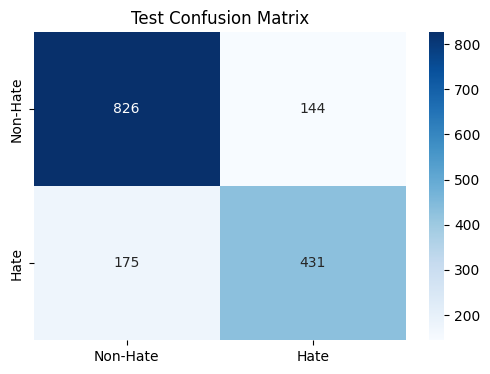


Training Tamilhate-BERT


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/950M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.394200,0.389132,0.845884,0.851334
2,0.376100,0.381766,0.866706,0.876747
3,0.326500,0.366431,0.870413,0.876747
4,0.261700,0.403693,0.861691,0.866582
5,0.200500,0.396978,0.886131,0.893266
6,0.157700,0.412616,0.877726,0.883100
7,0.175300,0.413517,0.879891,0.884371
8,0.110300,0.397667,0.895291,0.899619
9,0.080900,0.456560,0.885040,0.890724
10,0.107000,0.444854,0.884811,0.889454



Tamilhate-BERT Test Results:



Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.92      0.91      0.91       970
        Hate       0.85      0.87      0.86       606

    accuracy                           0.89      1576
   macro avg       0.89      0.89      0.89      1576
weighted avg       0.89      0.89      0.89      1576



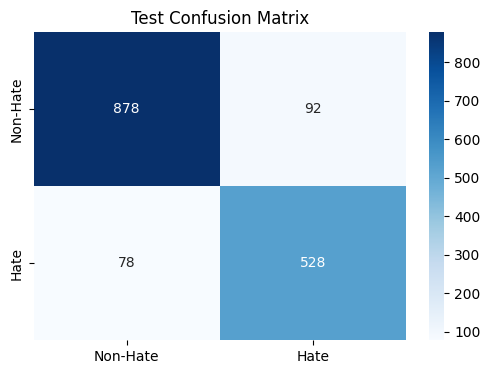


Training MuRIL


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.690000,0.687616,0.585304,0.588310
2,0.665100,0.667099,0.564343,0.566709
3,0.614500,0.672894,0.617230,0.692503
4,0.477700,0.608228,0.706225,0.717916
5,0.422700,0.618564,0.742798,0.770013
6,0.325200,0.651879,0.746282,0.776366
7,0.265800,0.722942,0.761232,0.781449
8,0.260700,0.740481,0.779483,0.794155
9,0.160700,0.856575,0.766916,0.783990
10,0.152200,0.853984,0.782190,0.795426



MuRIL Test Results:



Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.81      0.88      0.84       970
        Hate       0.78      0.68      0.72       606

    accuracy                           0.80      1576
   macro avg       0.80      0.78      0.78      1576
weighted avg       0.80      0.80      0.80      1576



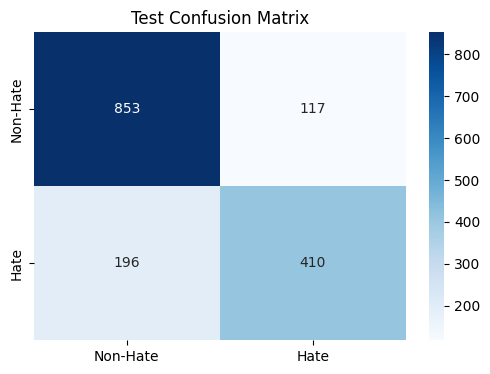


Training mBERT


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.686400,0.667319,0.582661,0.583227
2,0.674700,0.655720,0.533224,0.540025
3,0.586900,0.573230,0.685182,0.696315
4,0.439800,0.590729,0.667047,0.667090
5,0.273400,0.594327,0.779827,0.790343
6,0.191900,0.735918,0.779483,0.794155
7,0.133300,0.800547,0.782977,0.791614
8,0.098500,1.003962,0.791521,0.804320
9,0.077100,1.118800,0.784254,0.796696
10,0.037700,1.215435,0.791452,0.800508



mBERT Test Results:



Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.82      0.88      0.85       970
        Hate       0.78      0.68      0.73       606

    accuracy                           0.81      1576
   macro avg       0.80      0.78      0.79      1576
weighted avg       0.80      0.81      0.80      1576



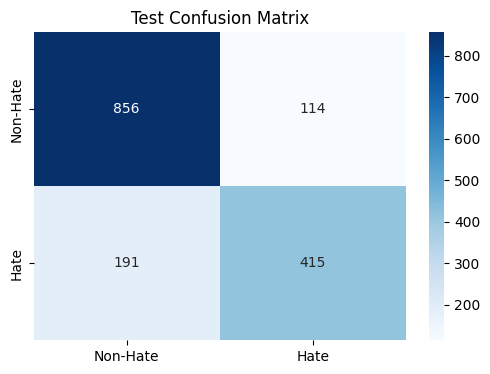


Training XLM-R


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.685300,0.681551,0.563254,0.566709
2,0.688800,0.679039,0.594909,0.599746
3,0.659300,0.645137,0.617761,0.651842
4,0.630700,0.620229,0.611040,0.611182
5,0.575000,0.601841,0.694508,0.697586
6,0.448700,0.612220,0.715894,0.728081
7,0.364200,0.630018,0.726233,0.729352
8,0.294000,0.709231,0.777380,0.791614
9,0.208400,0.704051,0.780095,0.794155
10,0.197700,0.784774,0.763946,0.773825



XLM-R Test Results:



Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.80      0.89      0.85       970
        Hate       0.79      0.65      0.71       606

    accuracy                           0.80      1576
   macro avg       0.80      0.77      0.78      1576
weighted avg       0.80      0.80      0.79      1576



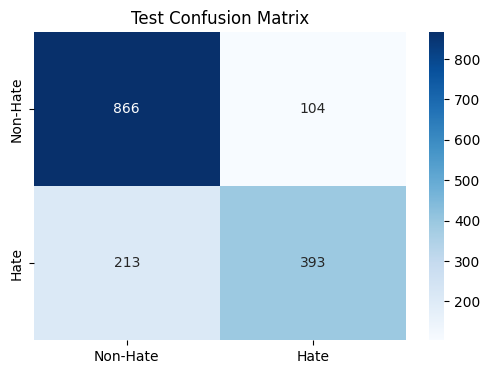

In [7]:
val_f1_scores = []
trained_models = []
all_test_preds = []

for model_name in MODELS:
    print(f"\n{'='*40}")
    print(f"Training {model_name}")
    print(f"{'='*40}")
    model, tokenizer, results, test_preds = train_model(model_name, train_df, dev_df, test_df)
    trained_models.append((model, tokenizer))
    val_f1_scores.append(results['eval_f1'])
    all_test_preds.append(test_preds)
    torch.cuda.empty_cache()


Ensemble Test Analysis:

Method: VOTING
              precision    recall  f1-score   support

    Non-Hate       0.83      0.91      0.87       970
        Hate       0.83      0.71      0.77       606

    accuracy                           0.83      1576
   macro avg       0.83      0.81      0.82      1576
weighted avg       0.83      0.83      0.83      1576



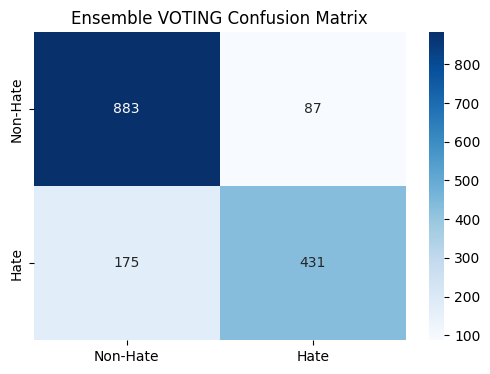


Method: AVERAGING
              precision    recall  f1-score   support

    Non-Hate       0.84      0.91      0.87       970
        Hate       0.83      0.71      0.77       606

    accuracy                           0.84      1576
   macro avg       0.83      0.81      0.82      1576
weighted avg       0.83      0.84      0.83      1576



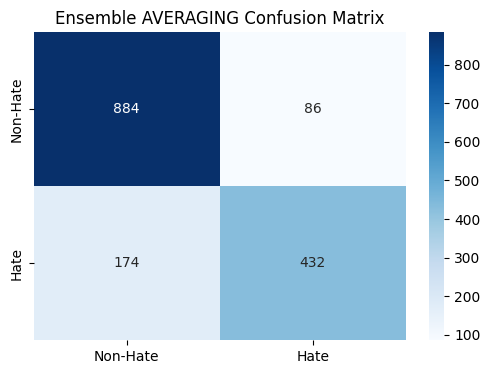


Method: WEIGHTED_VOTING
              precision    recall  f1-score   support

    Non-Hate       0.84      0.91      0.87       970
        Hate       0.83      0.72      0.77       606

    accuracy                           0.84      1576
   macro avg       0.84      0.81      0.82      1576
weighted avg       0.84      0.84      0.83      1576



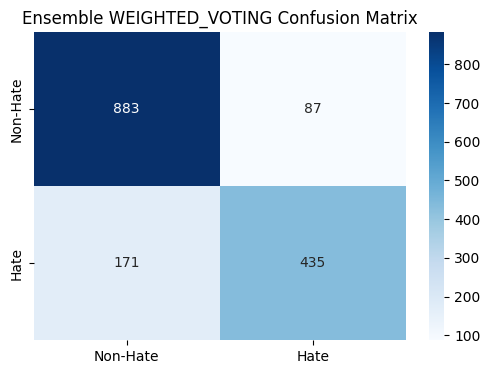

In [8]:
print("\nEnsemble Test Analysis:")
ensemble = EnsembleSystem(trained_models, val_f1_scores)

for method in ['voting', 'averaging', 'weighted_voting']:
    ensemble_preds = ensemble.predict(test_df['text'].tolist(), method=method)
    print(f"\nMethod: {method.upper()}")
    print(classification_report(test_df['label'], ensemble_preds,
                               target_names=['Non-Hate', 'Hate']))

    plt.figure(figsize=(6,4))
    cm = confusion_matrix(test_df['label'], ensemble_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'])
    plt.title(f'Ensemble {method.upper()} Confusion Matrix')
    plt.show()